<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Segmentation/blob/main/Image_Segmentation_using_Composable_Fully_Convolutional_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Fully-Convolutional Network for Image Segmentation.

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 04/07/2024
<br>
**Reference:**
- [Fully Convolutional Networks for Semantic Segmentation](https://doi.org/10.48550/arXiv.1411.4038)

- [Keras Example](https://keras.io/examples/vision/fully_convolutional_network/)


## Introduction

This example demonstrates how to implement Fully-Convolutional Networks (FCNs) for image segmentation using the Oxford-IIIT Pets dataset, based on the model proposed by Long et al. in their 2014 paper, "Fully Convolutional Networks for Semantic Segmentation."

Image segmentation extends the problem of image classification from assigning one label per image to performing pixel-wise classification. In this example, we will build the FCN architecture for this task. The model utilizes outputs from the VGG19 network's 3rd, 4th, and 5th max-pooling layers, which are upsampled to create a final segmentation map. Each pixel in this map is assigned a class label instead of an intensity value.

The FCN architecture has three versions, each with varying levels of detail and quality:
- **FCN-32S**: The simplest version with a single upsampling step.
- **FCN-16S**: Combines the output from the 4th max-pooling layer with upsampled features.
- **FCN-8S**: Incorporates outputs from the 3rd, 4th, and 5th max-pooling layers for the highest level of detail.


| ![FCN Architecture](https://i.imgur.com/Ttros06.png) |
| :--: |
| **Diagram 1**: Combined Architecture Versions (Source: Paper) |

## Setup Imports

In [2]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

## Set configurations for notebook variables

In [2]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 5 #20
BATCH_SIZE = 32
MIXED_PRECISION = True
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
  policy = keras.mixed_precision.Policy('mixed_float16')
  keras.mixed_precision.set_global_policy(policy)

## Load dataset

In [3]:
(train_ds, valid_ds, test_ds) = tfds.load(
    'oxford_iiit_pet',
    split=['train[:85%]', 'train[85%:]', 'test'],
    batch_size=BATCH_SIZE,
    shuffle_files=SHUFFLE,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4RTUCA_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.4RTUCA_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Unpack and preprocess dataset

In [4]:
def unpack_resize_data(section):
  image = section['image']
  segmentation_mask = section['segmentation_mask']

  resize_layer = keras.layers.Resizing(INPUT_HEIGHT, INPUT_WIDTH)

  image = resize_layer(image)
  segmentation_mask = resize_layer(segmentation_mask)

  return image, segmentation_mask

train_ds = train_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(unpack_resize_data, num_parallel_calls=AUTOTUNE)

## Visualize one random sample from the pre-processed dataset

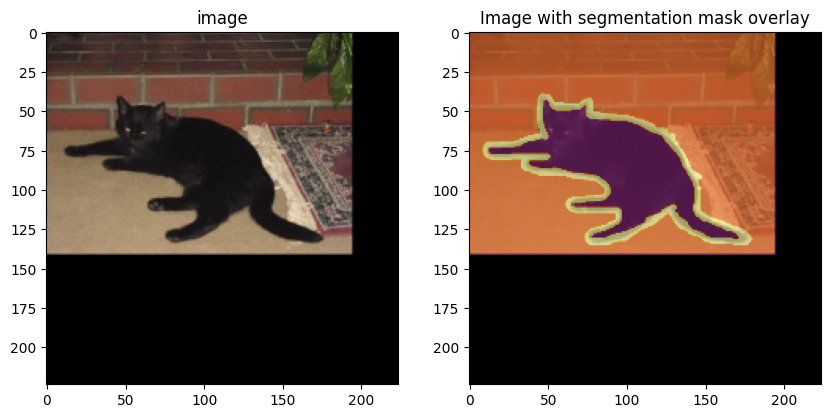

In [5]:
images, masks = next(iter(test_ds))
random_idx = keras.random.uniform([], minval=0, maxval=BATCH_SIZE, seed=10)

test_image = images[int(random_idx)].numpy().astype('float')
test_mask = masks[int(random_idx)].numpy().astype('float')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set_title('image')
ax[0].imshow(test_image / 255.0)

ax[1].set_title('Image with segmentation mask overlay')
ax[1].imshow(test_image / 255.0)
ax[1].imshow(
    test_mask,
    cmap='inferno',
    alpha=0.6,
)
plt.show()

## Perform VGG-specific pre-processing

In [6]:
def preprocess_data(image, segmentation_mask):
  image = keras.applications.vgg19.preprocess_input(image)

  return image, segmentation_mask

train_ds = (
    train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)

valid_ds = (
    valid_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)

test_ds = (
    test_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1024)
    .prefetch(buffer_size=1024)
)

## Model Definition


| ![Generic FCN Architecture](https://i.imgur.com/PerTKjf.png) |
| :--: |
| **Diagram 2**: Generic FCN Forward Pass (Source: Paper) |

Pixel-wise prediction in image segmentation is achieved using a Softmax convolutional layer that matches the size of the input image, allowing for a direct comparison between predicted and actual class labels for each pixel. This enables the calculation of important metrics to evaluate the network's performance, such as Accuracy and Mean Intersection over Union (Mean IoU). These metrics provide insights into how well the model is segmenting the image by assessing the proportion of correctly predicted pixels and the overlap between predicted and ground truth segments.

### Backbone (VGG-19)

We use the VGG-19 network as the backbone for our Fully-Convolutional Networks (FCNs) based on recommendations from the original paper, as it is considered highly effective for this task. Here are the key steps involved:

1. **Extracting Outputs**:
   - We utilize `keras.models.Model` to extract different outputs from the VGG-19 network.
   - These outputs come from the 3rd, 4th, and 5th max-pooling layers.

2. **Adding Layers**:
   - We add additional layers on top of these outputs to create a network that aligns with the architecture depicted in Diagram 1 of the paper.
   - The fully connected (`Dense`) layers of VGG-19 are converted to convolutional (`Conv2D`) layers, as per the original Caffe implementation.

3. **Network Variants**:
   - **FCN-32S**: The simplest version, using a single upsampling step.
   - **FCN-16S**: Combines output from the 4th max-pooling layer with upsampled features.
   - **FCN-8S**: Uses outputs from the 3rd, 4th, and 5th max-pooling layers for the highest detail.

4. **Weight Sharing**:
   - All three network variants share the same backbone weights but produce different results based on their upsampling and layer combination strategies.

5. **Non-trainable Backbone**:
   - To reduce training time, we make the backbone non-trainable.
   - According to the paper, making the backbone trainable does not significantly improve performance.

In [7]:
input_layer = keras.Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))

# VGG Model backbone with pretrained ImageNet weights
vgg_model = keras.applications.vgg19.VGG19(
    include_top=True,
    weights='imagenet',
)

# Extracting different outputs from same model
fcn_backbone = keras.models.Model(
    inputs=vgg_model.layers[1].input,
    outputs=[
        vgg_model.get_layer(block_name).output
        for block_name in ['block3_pool', 'block4_pool', 'block5_pool']
    ],
)

# Setting backbone to be non-trainable
fcn_backbone.trainable=False

x = fcn_backbone(input_layer)

# Converting Dense layers to Conv2D layers
units = [4096, 4096]
dense_convs = []

for filter_idx in range(len(units)):
  dense_conv = keras.layers.Conv2D(
      filters=units[filter_idx],
      kernel_size=(7, 7) if filter_idx == 0 else (1, 1),
      strides=(1, 1),
      activation='relu',
      padding='same',
      use_bias=False,
      kernel_initializer=keras.initializers.Constant(1.0),
  )
  dense_convs.append(dense_conv)
  dropout_layer = keras.layers.Dropout(0.5)
  dense_convs.append(dropout_layer)

dense_convs = keras.Sequential(dense_convs)
dense_convs.trainable = False

x[-1] = dense_convs(x[-1])

pool3_output, pool4_output, pool5_output = x

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


### FCN-32S

The FCN-32S architecture is the simplest variant of Fully Convolutional Networks for image segmentation. Here’s how it is implemented:

1. **Extension of the Last Output**:
   - The final output of the VGG-19 backbone is taken and extended.

2. **1x1 Convolution**:
   - A `keras.layers.Conv2D` layer with a 1x1 kernel is applied to reduce the depth of the feature map to the number of classes in the segmentation task.

3. **2D Bilinear Upsampling**:
   - To match the spatial dimensions of the input image, we perform 2D bilinear upsampling by a factor of 32. This step transforms the feature map to have the same height and width as the input image.
   - We use `keras.layers.UpSampling2D` for this purpose instead of `keras.layers.Conv2DTranspose` because `UpSampling2D` is a deterministic mathematical operation, which generally provides performance benefits over the convolutional operation of `Conv2DTranspose`.

4. **Non-trainable Upsampling Parameters**:
   - The upsampling parameters are not made trainable, as the paper notes that making them trainable does not offer significant benefits.
   - The original experiments in the paper also used upsampling without trainable parameters.


In [8]:
# 1x1 convolution to set channels = numbers of classes
pool5 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding='same',
    strides=(1, 1),
    activation='relu',
)

# Get Softmax outputs for all classes
fcn32s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation='softmax',
    padding='same',
    strides=(1, 1),
)

# Up-sample to original image size
fcn32s_upsampling = keras.layers.UpSampling2D(
    size=(32, 32),
    data_format=keras.backend.image_data_format(),
    interpolation='bilinear',
)

final_fcn32s_pool = pool5(pool5_output)
final_fcn32s_output = fcn32s_conv_layer(final_fcn32s_pool)
final_fcn32s_output = fcn32s_upsampling(final_fcn32s_output)

fcn32s_model = keras.Model(inputs=input_layer, outputs=final_fcn32s_output)

## FCN-16S

The pooling output from the FCN-32S is extended and added to the 4th-level Pooling output of our backbone. Following this, we upsample by a factor of 16 to get image of the same size as that of our input.

In [9]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool4 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding='same',
    strides=(1, 1),
    activation='relu',
    kernel_initializer=keras.initializers.Zeros(),
)(pool4_output)

# Intermediate up-sample
pool5 = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation='bilinear',
)(final_fcn32s_pool)

# Get Softmax output for all classes
fcn16s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation='softmax',
    padding='same',
    strides=(1, 1),
)

# Up-sample to original image size
fcn16s_upsample_layer = keras.layers.UpSampling2D(
    size=(16, 16),
    data_format=keras.backend.image_data_format(),
    interpolation='bilinear',
)

# Add intermediate outputs
final_fcn16s_pool = keras.layers.Add()([pool4, pool5])
final_fcn16s_outout = fcn16s_conv_layer(final_fcn16s_pool)
final_fcn16s_output = fcn16s_upsample_layer(final_fcn16s_outout)

fcn16s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn16s_output)

## FCN-8S

The pooling output from the FCN-16S is extended once more, and added from the 3rd-level Pooling output of our backbone. This result is upsampled by a factor of 8 to get an image of the same size as that of our input.

In [10]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool3 = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    padding='same',
    strides=(1, 1),
    activation='linear',
    kernel_initializer=keras.initializers.Zeros(),
)(pool3_output)

# Intermediate up-sample
intermediate_pool_output = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation='bilinear',
)(final_fcn16s_pool)

# Get Softmax outputs for all classes
fcn8s_conv_layer = keras.layers.Conv2D(
    filters=NUM_CLASSES,
    kernel_size=(1, 1),
    activation='softmax',
    padding='same',
    strides=(1, 1),
)

# Up-sample to original image size
fcn8s_upsample_layer = keras.layers.UpSampling2D(
    size=(8, 8),
    data_format=keras.backend.image_data_format(),
    interpolation='bilinear',
)

# Add intermediate outputs
final_fcn8s_pool = keras.layers.Add()([pool3, intermediate_pool_output])
final_fcn8s_output = fcn8s_conv_layer(final_fcn8s_pool)
final_fcn8s_output = fcn8s_upsample_layer(final_fcn8s_output)

fcn8s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn8s_output)

## Load weights into backbone
It was noted in the paper, as well as through experimentation that extracting the weights of the last 2 Fully-connected Dense layers from the backbone, reshaping the weights to fit that of the keras.layers.Dense layers we had previously converted into keras.layers.Conv2D, and setting them to it yields far better results and a significant increase in mIOU performance.

In [11]:
# VGG's last 2 layers
weights1 = vgg_model.get_layer('fc1').get_weights()[0]
weights2 = vgg_model.get_layer('fc2').get_weights()[0]

weights1 = weights1.reshape(7, 7, 512, 4096)
weights2 = weights2.reshape(1, 1, 4096, 4096)

dense_convs.layers[0].set_weights([weights1])
dense_convs.layers[2].set_weights([weights2])

## Training
The original paper talks about making use of SGD with Momentum as the optimizer of choice. But it was noticed during experimentation that AdamW yielded better results in terms of mIOU and Pixel-wise Accuracy.

### FCN-32S

In [12]:
fcn32s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

fcn32s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn32s_model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn32s_history = fcn32s_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 208s 890ms/step - loss: 1.2620 - mean_io_u: 0.1323 - sparse_categorical_accuracy: 0.4639 - val_loss: 1.0355 - val_mean_io_u: 0.2663 - val_sparse_categorical_accuracy: 0.6028
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 214ms/step - loss: 0.9084 - mean_io_u: 0.2192 - sparse_categorical_accuracy: 0.6429 - val_loss: 0.9324 - val_mean_io_u: 0.3165 - val_sparse_categorical_accuracy: 0.6620
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 85s 200ms/step - loss: 0.8374 - mean_io_u: 0.2613 - sparse_categorical_accuracy: 0.6851 - val_loss: 0.8564 - val_mean_io_u: 0.3222 - val_sparse_categorical_accuracy: 0.6683
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 126s 181ms/step - loss: 0.8440 - mean_io_u: 0.2937 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.8100 - val_mean_io_u: 0.4302 - val_sparse_categorical_accuracy: 0.7182
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 94s 198ms/step - loss: 0.7759 - mean_io_u: 0.3466 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.7745 - val_mean_io

## FCN-16S

In [14]:
fcn16s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

fcn16s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy Metrics
fcn16s_model.compile(
    optimizer=fcn16s_optimizer,
    loss=fcn16s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy()
    ],
)

fcn16s_history = fcn16s_model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 78s 261ms/step - loss: 1.7769 - mean_io_u_1: 0.1340 - sparse_categorical_accuracy: 0.4243 - val_loss: 1.1508 - val_mean_io_u_1: 0.3033 - val_sparse_categorical_accuracy: 0.6429
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 109s 299ms/step - loss: 1.0989 - mean_io_u_1: 0.2445 - sparse_categorical_accuracy: 0.6461 - val_loss: 1.0624 - val_mean_io_u_1: 0.3120 - val_sparse_categorical_accuracy: 0.6554
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 86s 194ms/step - loss: 1.0005 - mean_io_u_1: 0.2559 - sparse_categorical_accuracy: 0.6661 - val_loss: 1.0064 - val_mean_io_u_1: 0.3196 - val_sparse_categorical_accuracy: 0.6663
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 150s 299ms/step - loss: 0.9557 - mean_io_u_1: 0.2612 - sparse_categorical_accuracy: 0.6738 - val_loss: 0.9682 - val_mean_io_u_1: 0.3230 - val_sparse_categorical_accuracy: 0.6711
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 133s 180ms/step - loss: 0.9113 - mean_io_u_1: 0.2630 - sparse_categorical_accuracy: 0.6797 - val_loss: 0.

## FCN-8S

In [15]:
fcn8s_optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

fcn8s_loss = keras.losses.SparseCategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
fcn8s_model.compile(
    optimizer=fcn8s_optimizer,
    loss=fcn8s_loss,
    metrics=[
        keras.metrics.MeanIoU(num_classes=NUM_CLASSES, sparse_y_pred=False),
        keras.metrics.SparseCategoricalAccuracy(),
    ],
)

fcn8s_history = fcn8s_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 99s 273ms/step - loss: 4.4325 - mean_io_u_2: 0.2358 - sparse_categorical_accuracy: 0.5426 - val_loss: 1.4883 - val_mean_io_u_2: 0.5590 - val_sparse_categorical_accuracy: 0.7968
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 58s 156ms/step - loss: 1.2070 - mean_io_u_2: 0.5549 - sparse_categorical_accuracy: 0.8313 - val_loss: 1.0568 - val_mean_io_u_2: 0.6186 - val_sparse_categorical_accuracy: 0.8365
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - loss: 0.9587 - mean_io_u_2: 0.5890 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.9457 - val_mean_io_u_2: 0.6312 - val_sparse_categorical_accuracy: 0.8445
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 158ms/step - loss: 0.8635 - mean_io_u_2: 0.6007 - sparse_categorical_accuracy: 0.8557 - val_loss: 0.8994 - val_mean_io_u_2: 0.6320 - val_sparse_categorical_accuracy: 0.8405
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 155ms/step - loss: 0.8490 - mean_io_u_2: 0.5987 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.875

## Visualizations

### Plotting metrics for training run

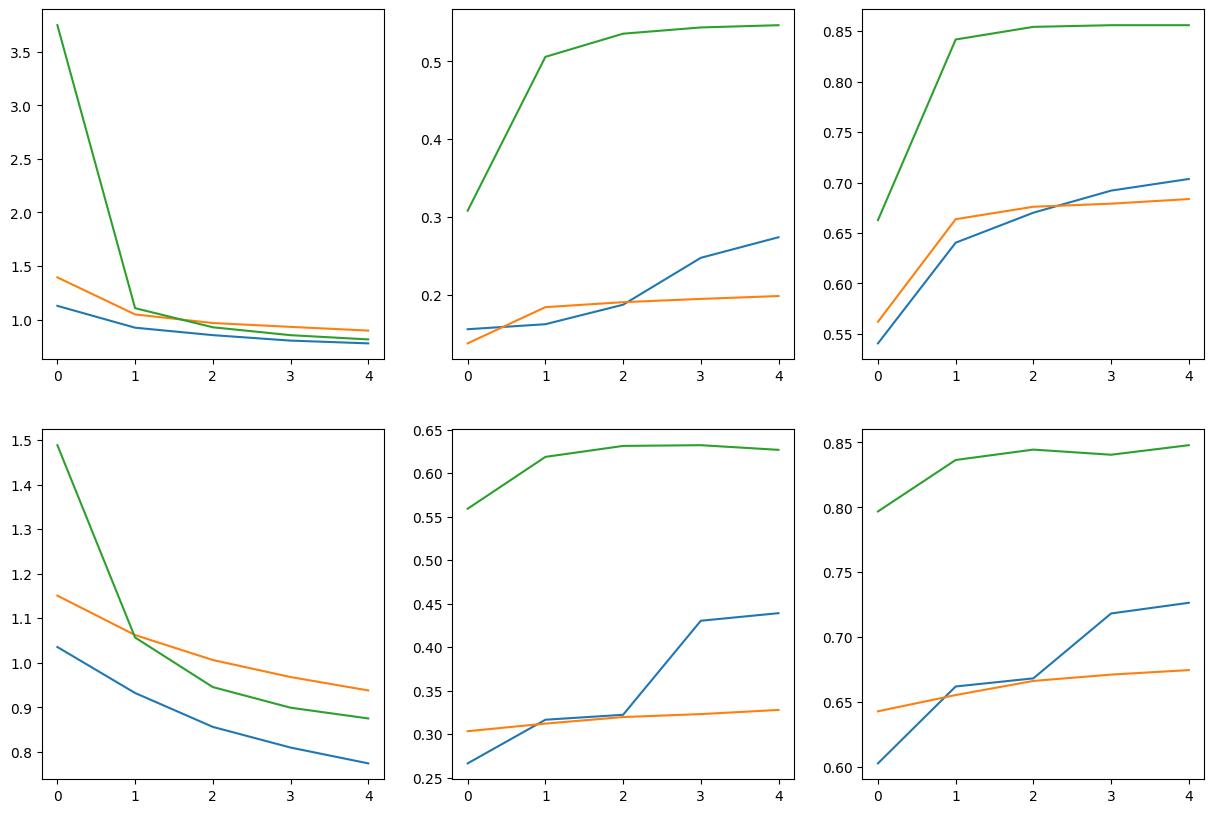

In [16]:
total_plots = len(fcn32s_history.history)
cols = total_plots // 2

rows = total_plots // cols

if total_plots % cols !=0:
  rows += 1

# Set all history dictionary objects
fcn32s_dict = fcn32s_history.history
fcn16s_dict = fcn16s_history.history
fcn8s_dict = fcn8s_history.history

pos = range(1, total_plots + 1)
plt.figure(figsize=(15, 10))

for i, ((key_32s, value_32s), (key_16s, value_16s), (key_8s, value_8s)) in enumerate(
    zip(fcn32s_dict.items(), fcn16s_dict.items(), fcn8s_dict.items())
):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value_32s)), value_32s)
    plt.plot(range(len(value_16s)), value_16s)
    plt.plot(range(len(value_8s)), value_8s)
    plt.title(key_32s) + '(combined)'
    plt.legend(['FCN-32S', 'FCN-16S', 'FCN-8S'])

plt.show()

### Visualizing predicted segmentation masks

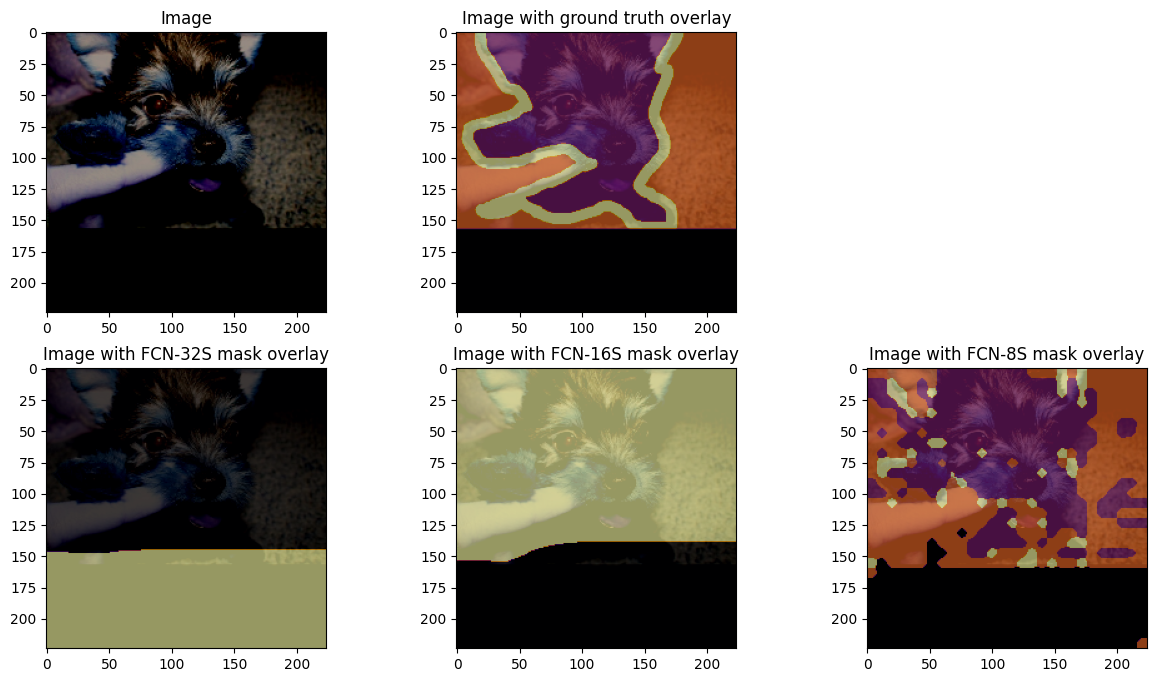

In [18]:
images, masks = next(iter(test_ds))
random_idx = keras.random.uniform([], minval=0, maxval=BATCH_SIZE,seed=10)

# Get random test image and mask
test_image = images[int(random_idx)].numpy().astype("float")
test_mask = masks[int(random_idx)].numpy().astype("float")

pred_image = ops.expand_dims(test_image, axis=0)
pred_image = keras.applications.vgg19.preprocess_input(pred_image)

# Perform inference on FCN-32S
pred_mask_32s = fcn32s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_32s = np.argmax(pred_mask_32s, axis=-1)
pred_mask_32s = pred_mask_32s[0, ...]

# Perform inference on FCN-16S
pred_mask_16s = fcn16s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_16s = np.argmax(pred_mask_16s, axis=-1)
pred_mask_16s = pred_mask_16s[0, ...]

# Perform inference on FCN-8S
pred_mask_8s = fcn8s_model.predict(pred_image, verbose=0).astype("float")
pred_mask_8s = np.argmax(pred_mask_8s, axis=-1)
pred_mask_8s = pred_mask_8s[0, ...]

# Plot all results
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

fig.delaxes(ax[0, 2])

ax[0, 0].set_title("Image")
ax[0, 0].imshow(test_image / 255.0)

ax[0, 1].set_title("Image with ground truth overlay")
ax[0, 1].imshow(test_image / 255.0)
ax[0, 1].imshow(
    test_mask,
    cmap="inferno",
    alpha=0.6,
)

ax[1, 0].set_title("Image with FCN-32S mask overlay")
ax[1, 0].imshow(test_image / 255.0)
ax[1, 0].imshow(pred_mask_32s, cmap="inferno", alpha=0.6)

ax[1, 1].set_title("Image with FCN-16S mask overlay")
ax[1, 1].imshow(test_image / 255.0)
ax[1, 1].imshow(pred_mask_16s, cmap="inferno", alpha=0.6)

ax[1, 2].set_title("Image with FCN-8S mask overlay")
ax[1, 2].imshow(test_image / 255.0)
ax[1, 2].imshow(pred_mask_8s, cmap="inferno", alpha=0.6)

plt.show()